# Can we detect climate misinformation by analysing a single word or phrase? (Twitter version)

* Download dataset from https://www.kaggle.com/edqian/twitter-climate-change-sentiment-dataset
* Unzip and save file in labelled_data folder

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import sys

pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.2%}'.format

sys.path.insert(0, '../text_preprocessing/')

In [2]:
from preprocessing import *
from embeddings import *

/usr/local/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
path = '../labelled_data/twitter_sentiment_data.csv'

print("Importing data...")
# df = import_data(path)
df = pd.read_csv(path, header=0)
df.drop(columns=["tweetid"], inplace=True)
df.columns = ["sentiment", "text"]

print("\nDropping na values..")
df = na_values(df)

print("\nEncoding classes..")
# df, label_columns = class_encoding(df)
df["human_label"] = df.sentiment.apply(lambda sentiment: 1 if sentiment > -1 else 0)
df.drop(columns=["sentiment"], inplace=True)

# # print("\nFiltering long doocuments and exploring length..")
# # documents_len_exploration_and_filter(df,max_len=1500)

print("\nStarting text preprocessing..")
clean_text = preprocessing(df)

df['clean_text'] = clean_text

print(len(df))
df.head()

Importing data...

Dropping na values..
NaN values per column
sentiment    0
text         0
dtype: int64

Encoding classes..

Starting text preprocessing..
43943


,text,human_label,clean_text
0,@tiniebeany climate change is an interesting h...,0,"[tiniebeany, climate, change, interest, hustle..."
1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,1,"[rt, natgeochannel, watch, beforetheflood, rig..."
2,Fabulous! Leonardo #DiCaprio's film on #climat...,1,"[fabulous, leonardo, dicaprios, film, climate,..."
3,RT @Mick_Fanning: Just watched this amazing do...,1,"[rt, mickfanning, watch, amaze, documentary, l..."
4,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",1,"[rt, cnalive, pranita, biswasi, lutheran, odis..."


## Wordclouds for each Class

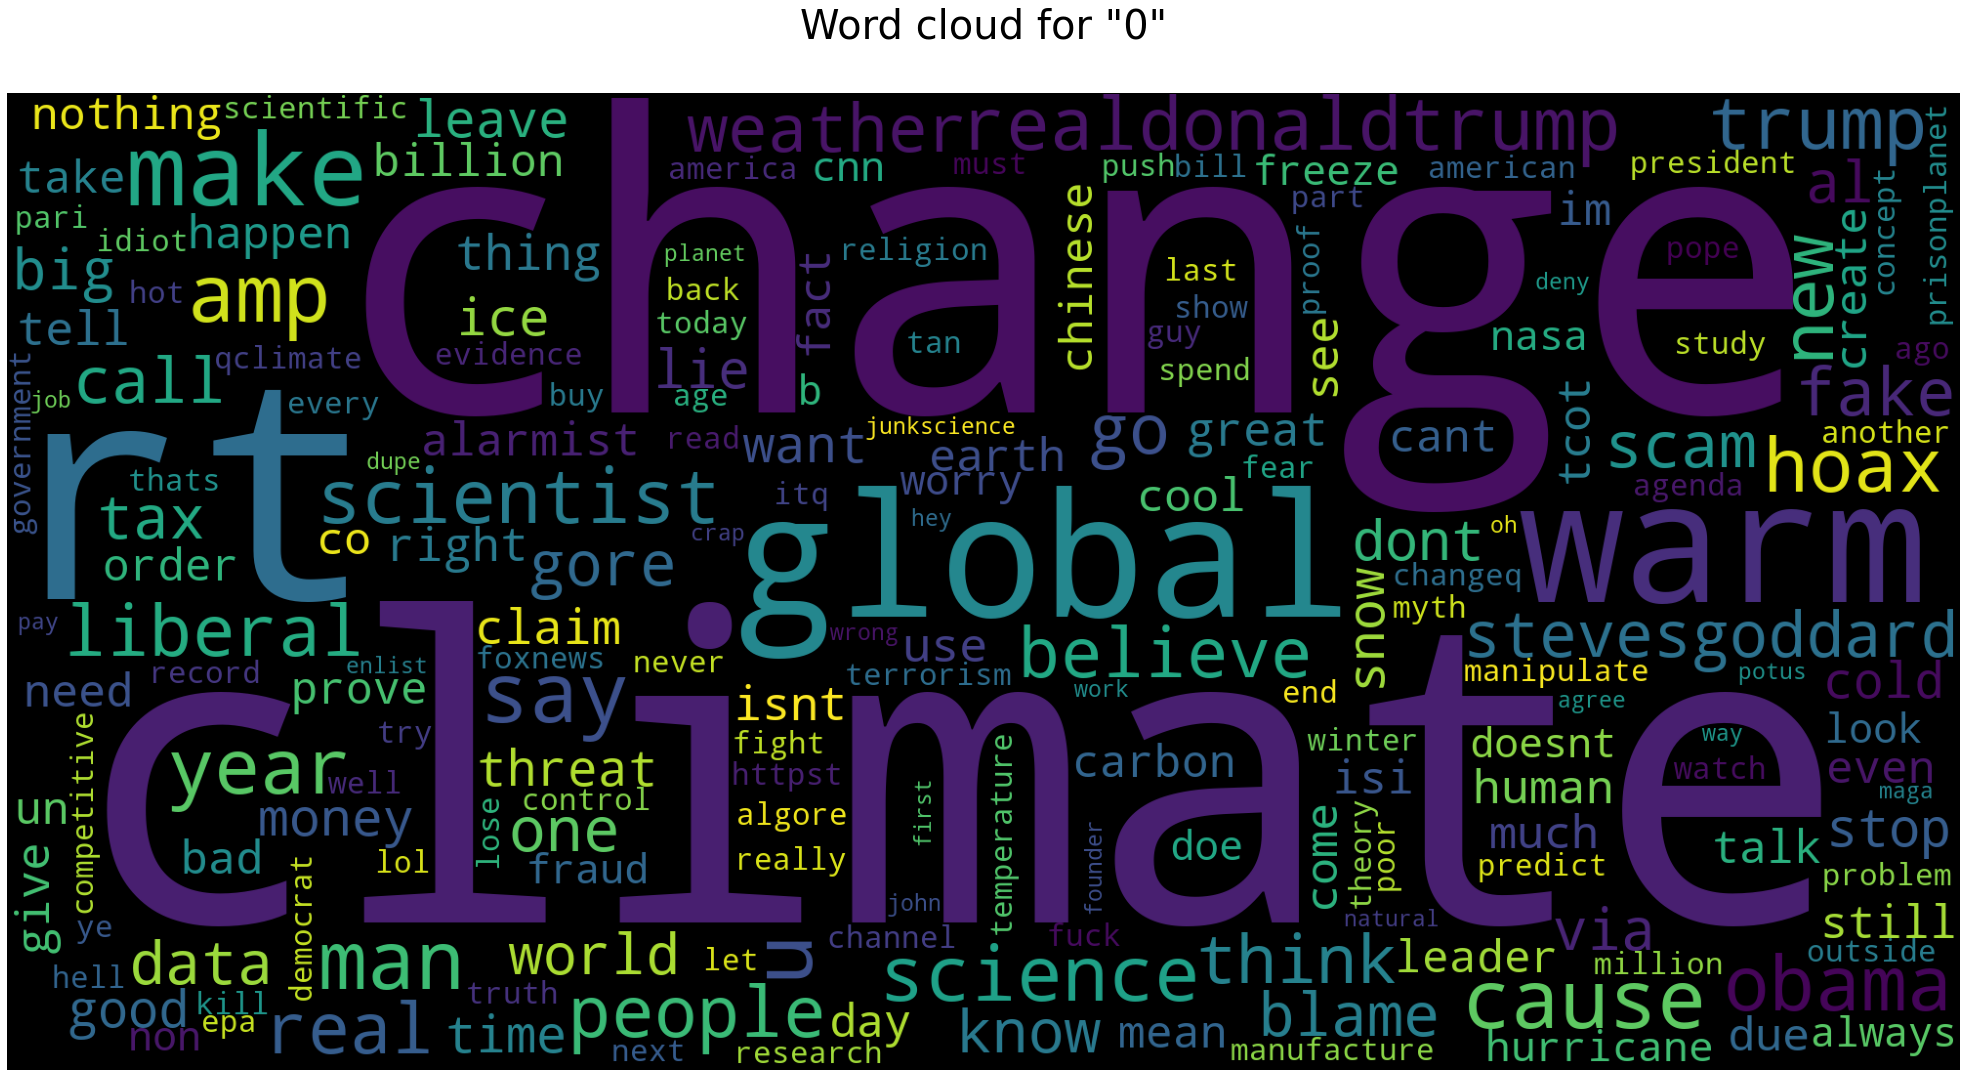



#########




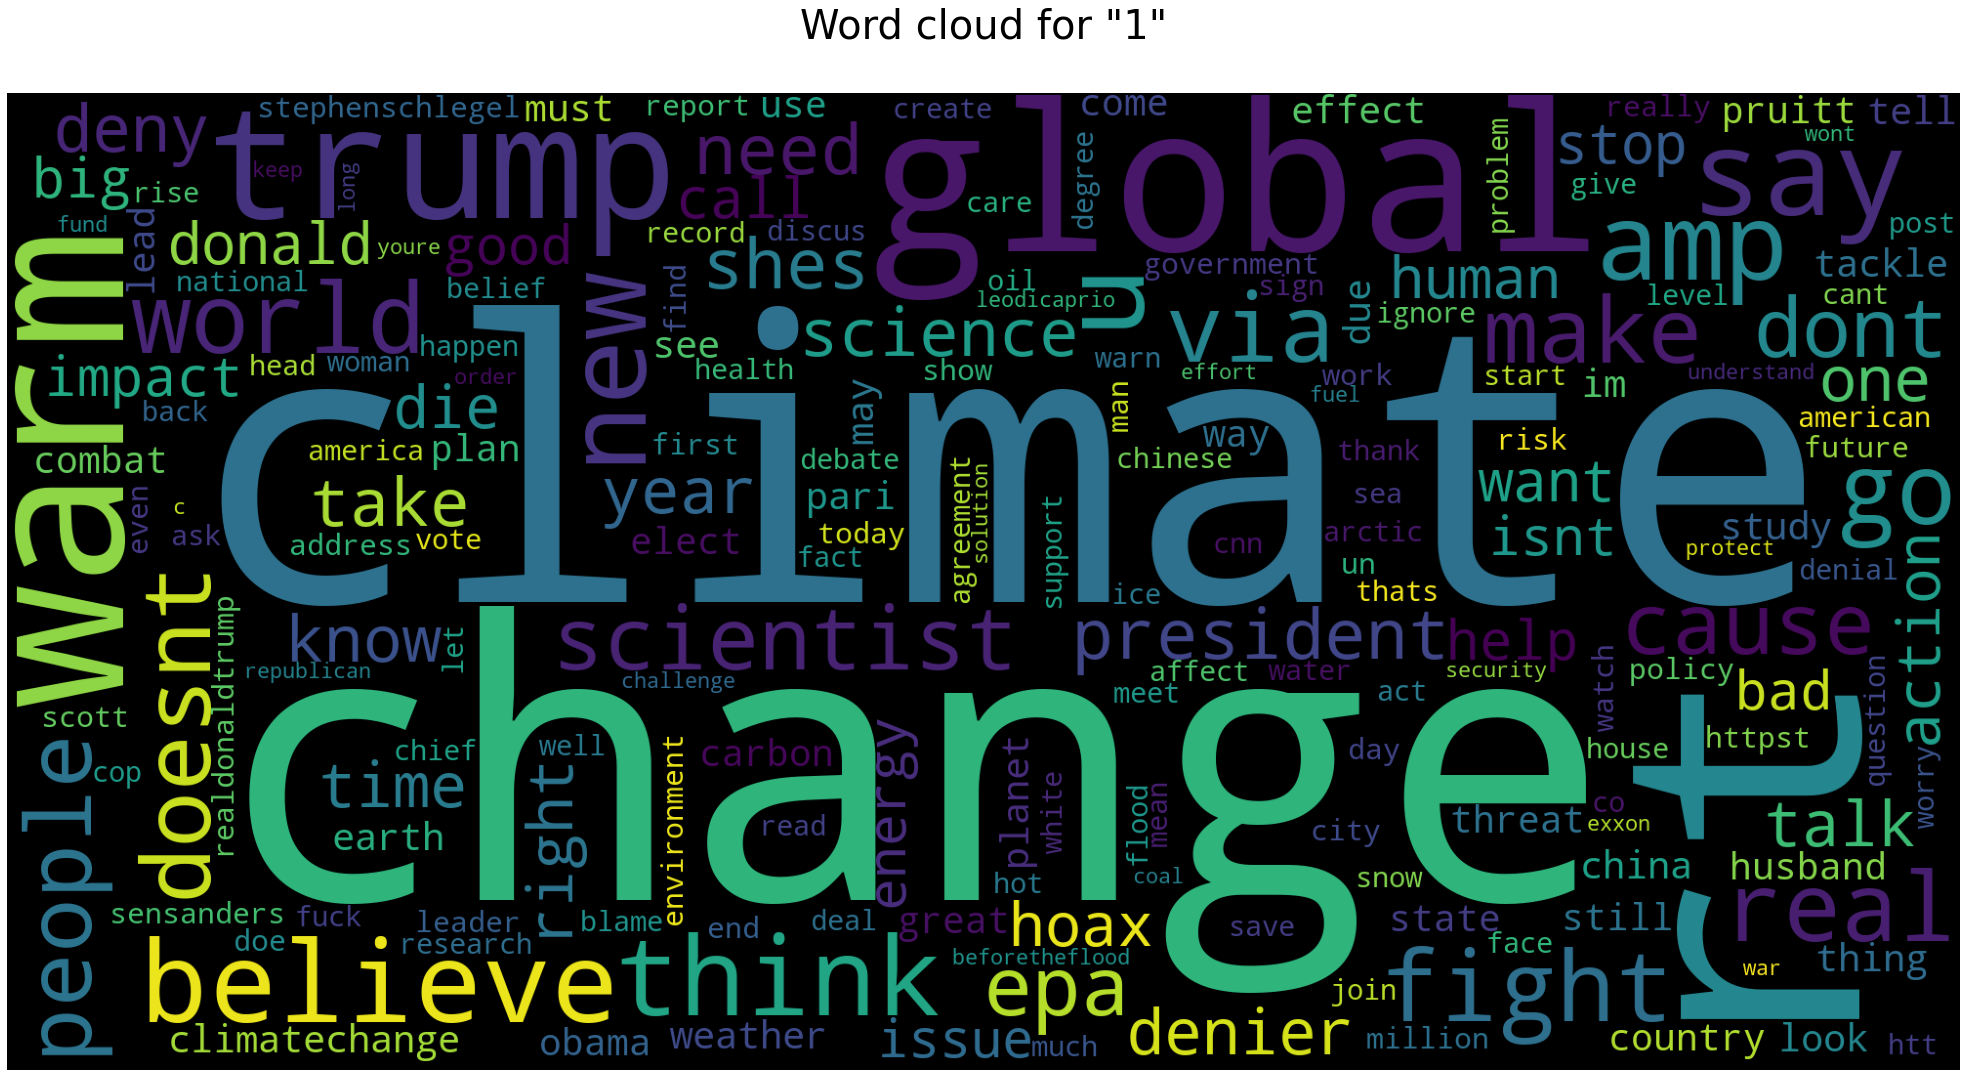



#########




In [4]:
def plot_wordcloud(label):

    plt.figure(figsize=(35,20))

    full_text = ""
    for doc in df[df.human_label == label].clean_text.to_list():
        for text in doc:
            full_text = "{0} {1}".format(full_text,text).strip()
    
    cloud_text = WordCloud(
                              stopwords=STOPWORDS,
                              background_color='black',
                              collocations=False,
                              width=2000,
                              height=1000
                             ).generate(full_text)
    plt.axis('off')
    plt.title('Word cloud for "{0}"\n'.format(label),fontsize=40)
    plt.imshow(cloud_text)
    plt.show()

for col in df.human_label.unique():
    plot_wordcloud(col)
    print("\n\n#########\n\n")

## Most frequent Keywords

In [5]:
top_n = []
n = 2000

for col in df.human_label.unique():
    print(col)
    words = []
    for doc in df.loc[df.human_label == col, 'clean_text'].to_list():
        words += doc

    d = {
        "label": col,
        "top_{0}".format(n): pd.Series(words).value_counts()[:n].index
    }
    top_n.append(d)

top_n

0
1


[{'label': 0,
  'top_2000': Index(['climate', 'change', 'rt', 'global', 'warm', 'make', 'say', 'cause',
         'man', 'amp',
         ...
         'usually', 'dry', 'biosludge', 'propagandist', 'skynews', 'separate',
         'sing', 'goreeffect', 'purely', 'exjon'],
        dtype='object', length=2000)},
 {'label': 1,
  'top_2000': Index(['climate', 'change', 'rt', 'global', 'warm', 'trump', 'say', 'believe',
         'think', 'us',
         ...
         'insane', 'lgbtq', 'christophernfox', 'buzzfeednews', 'killer',
         'legacy', 'immediate', 'weekend', 'yahoonews', 'mercer'],
        dtype='object', length=2000)}]

In [6]:
analysed_words = []

def word_analysis(word_list, min_length=4, min_freq=0.0, max_freq_other=1.0):

    data_list = []
    for word in sorted(word_list):
        if len(word) < min_length:
            continue

        mask = df.clean_text.apply(lambda x: word in x)
        freq = df.loc[mask, "human_label"].value_counts() / df.human_label.value_counts()
        if (freq[0] < min_freq) or (freq[1] > max_freq_other):
            continue

        print("\n\n##### {0}\n".format(word))
        print(freq)
        data = pd.DataFrame(freq).T
        data["word"] = word
        data_list.append(data)

    print("\n\n##### {0} words selected for analysis".format(len(data_list)))
        
    return data_list

analysed_words += word_analysis(top_n[0]["top_{0}".format(n)], min_length=4, min_freq=0.3, max_freq_other=0.3)



##### global

1   21.98%
0   46.07%
Name: human_label, dtype: float64


##### warm

1   20.59%
0   45.24%
Name: human_label, dtype: float64


##### 2 words selected for analysis


## Most frequent Keywords (misinfo focus)

In [7]:
top_misinfo_only = []

for val in top_n[0]["top_{0}".format(n)]:
    if (val in top_n[1]["top_{0}".format(n)]):
        continue
    top_misinfo_only.append(val)

print("{0} of top {1} misinfo not in other top {1}s".format(len(top_misinfo_only), n))

analysed_words += word_analysis(top_misinfo_only, min_length=4, min_freq=0.3, max_freq_other=0.3)

749 of top 2000 misinfo not in other top 2000s


##### 0 words selected for analysis


## Curated Keywords from Notion

In [8]:
notion_words_misinfo = ["climatecult", "climatehysteria", "globalcooling", "climatescam", "climatehoax", "climatechangehoax",
                        "greenwashing"]

notion_words_climate = ["TheTimeIsNow", "weneedexperts", "ecology", "climatechange", "HowtoSavethePlanet", "VoiceForThePlanet",
                        "FightForYourWorld", "connect2earth", "globalwarming"]

notion_words_notrel = ["coronavirus"]

notion_keywords = [
    {"label": "Climate Misinformation", "words": notion_words_misinfo},
    {"label": "Climate Related", "words": notion_words_climate},
    {"label": "Not Climate Related", "words": notion_words_notrel},
]

for k in notion_keywords:
    print("\n-------------------------------\n{0}\n{1}".format(k["label"], k["words"]))
    analysed_words += word_analysis(k["words"])


-------------------------------
Climate Misinformation
['climatecult', 'climatehysteria', 'globalcooling', 'climatescam', 'climatehoax', 'climatechangehoax', 'greenwashing']


##### climatechangehoax

0   0.13%
1     NaN
Name: human_label, dtype: float64


##### climatecult

1   NaN
0   NaN
Name: human_label, dtype: float64


##### climatehoax

0   0.05%
1     NaN
Name: human_label, dtype: float64


##### climatehysteria

1   NaN
0   NaN
Name: human_label, dtype: float64


##### climatescam

0   0.18%
1     NaN
Name: human_label, dtype: float64


##### globalcooling

0   0.03%
1   0.00%
Name: human_label, dtype: float64


##### greenwashing

1   NaN
0   NaN
Name: human_label, dtype: float64


##### 7 words selected for analysis

-------------------------------
Climate Related
['TheTimeIsNow', 'weneedexperts', 'ecology', 'climatechange', 'HowtoSavethePlanet', 'VoiceForThePlanet', 'FightForYourWorld', 'connect2earth', 'globalwarming']


##### FightForYourWorld

1   NaN
0   NaN
Name: hum

## Summary

In [9]:
summary = pd.concat(analysed_words, ignore_index=True)
print(summary.columns)
summary.drop_duplicates(inplace=True)
summary.columns = ["Climate related", "Climate denying", "Word"]
print(summary.columns)
summary.set_index("Word", inplace=True)
summary["Precision (misinfo)"] = summary["Climate denying"]
summary["Recall (misinfo)"] = (summary["Climate denying"] * df[df.human_label == 0].shape[0]) / (
                                    (summary["Climate denying"] * df[df.human_label == 0].shape[0])
                                    + (summary["Climate related"] * df[df.human_label == 1].shape[0])
#                                     + (summary["Non climate"] * df[df.human_label == 2].shape[0])
                                )
summary["F1 (misinfo)"] = 2 * summary["Precision (misinfo)"] * summary["Recall (misinfo)"] / (
                                summary["Precision (misinfo)"] + summary["Recall (misinfo)"] 
                            )
summary.fillna(0, inplace=True)
summary.sort_values(by="F1 (misinfo)", ascending=False, inplace=True)

print("{0} words analysed".format(summary.shape[0]))
summary

Index([1, 0, 'word'], dtype='object')
Index(['Climate related', 'Climate denying', 'Word'], dtype='object')
19 words analysed


,Climate related,Climate denying,Precision (misinfo),Recall (misinfo),F1 (misinfo)
Word,,,,,
warm,20.59%,45.24%,45.24%,17.99%,25.74%
global,21.98%,46.07%,46.07%,17.31%,25.16%
climatechange,1.59%,0.65%,0.65%,3.93%,1.12%
globalwarming,0.35%,0.50%,0.50%,12.66%,0.96%
globalcooling,0.00%,0.03%,0.03%,50.00%,0.05%
TheTimeIsNow,0.00%,0.00%,0.00%,0.00%,0.00%
weneedexperts,0.00%,0.00%,0.00%,0.00%,0.00%
ecology,0.03%,0.00%,0.00%,0.00%,0.00%
connect2earth,0.00%,0.00%,0.00%,0.00%,0.00%
